In [ ]:
import pandas as pd 
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import accuracy_score
import numpy as np
import tensorflow as tf 
import matplotlib.pyplot as plt 
from tensorflow.keras.layers import SimpleRNN

#### Importazione del dataset 

In [3]:
data = pd.read_csv('data/datatest.txt')
data2 = pd.read_csv('data/datatraining.txt')
data3 = pd.read_csv('data/datatest2.txt')

#### Modifica data in formato DateTime e creazione di colonne che indicano lo spazio temporale 

In [4]:
print(data.iloc[0].date, data.iloc[-1].date)
print(data2.iloc[0].date, data2.iloc[-1].date)
print(data3.iloc[0].date, data3.iloc[-1].date)

2015-02-02 14:19:00 2015-02-04 10:43:00
2015-02-04 17:51:00 2015-02-10 09:33:00
2015-02-11 14:48:00 2015-02-18 09:19:00


In [5]:
data_all = pd.concat([data, data2, data3])
data_all['date'] = pd.to_datetime((data_all['date']))
data_all['Notte'] = 0.
data_all['Mattina'] = 0.
data_all['Mezzogiorno'] = 0.
data_all['Pomeriggio'] = 0.
data_all['Sera'] = 0.

data_all.loc[(data_all['date'].dt.hour < 8) | (data_all['date'].dt.hour > 21), 'Notte'] = 1. 
data_all.loc[(data_all['date'].dt.hour <= 12) & (data_all['date'].dt.hour >= 8), 'Mattina'] = 1.
data_all.loc[(data_all['date'].dt.hour > 12) & (data_all['date'].dt.hour <= 15), 'Mezzogiorno'] = 1.
data_all.loc[(data_all['date'].dt.hour > 15) & (data_all['date'].dt.hour <= 18), 'Pomeriggio'] = 1.
data_all.loc[(data_all['date'].dt.hour > 18) & (data_all['date'].dt.hour <= 21), 'Sera'] = 1.

data_all.drop_duplicates(inplace=True)

data_all['Occupato'] = data_all['Occupancy']
del data_all['Occupancy']

data_all.set_index('date', inplace = True)
data_all.head()

,Temperature,Humidity,Light,CO2,HumidityRatio,Notte,Mattina,Mezzogiorno,Pomeriggio,Sera,Occupato
date,,,,,,,,,,,
2015-02-02 14:19:00,23.7000,26.272,585.200000,749.200000,0.004764,0.0,0.0,1.0,0.0,0.0,1
2015-02-02 14:19:59,23.7180,26.290,578.400000,760.400000,0.004773,0.0,0.0,1.0,0.0,0.0,1
2015-02-02 14:21:00,23.7300,26.230,572.666667,769.666667,0.004765,0.0,0.0,1.0,0.0,0.0,1
2015-02-02 14:22:00,23.7225,26.125,493.750000,774.750000,0.004744,0.0,0.0,1.0,0.0,0.0,1
2015-02-02 14:23:00,23.7540,26.200,488.600000,779.000000,0.004767,0.0,0.0,1.0,0.0,0.0,1


In [6]:
dataset = data_all.values

#### Creazione dei dati di train e di test

In [7]:
split_point = int(len(dataset) * 0.95)

x_train = dataset[:split_point, :-1]
y_train = dataset[:split_point,-1]

x_test = dataset[split_point:,:-1]
y_test = dataset[split_point:,-1]

#### Normalizzazione dei dati

In [8]:
scaler = StandardScaler()
scaler.fit(x_train)

x_train_std = scaler.transform(x_train)
x_test_std = scaler.transform(x_test)

#### Funzione sull accertamento del corretto funzionamento delle serie temporali

In [9]:
def get_time_series(features, labels, steps_back):
    assert len(features) == len(labels)
    assert steps_back > 0
    ts_features = []
    ts_labels = []
    for i in range( steps_back, len(features) +1):
        ts_features.append(features[i - steps_back:i])
        ts_labels.append(labels[i - 1])
    return np.asarray(ts_features), np.asarray(ts_labels)

steps_back = 60 
x_train_ts, y_train_ts = get_time_series(x_train_std, y_train, steps_back)
x_test_ts, y_test_ts = get_time_series(x_test_std, y_test, steps_back) 

In [10]:
assert np.all(x_train_ts[0][0] == x_train_std[0])
assert y_train_ts[0] == y_train[steps_back]

assert np.all(x_train_ts[42][0] == x_train_std[42])
assert y_train_ts[42] == y_train[42 + steps_back]

assert np.all(x_test_ts[0][0] == x_test_std[0])
assert y_test_ts[0] == y_test[steps_back]

assert np.all(x_test_ts[42][0] == x_test_std[42])
assert y_test_ts[42] == y_test[42 + steps_back]

#### Creazione del architettura del modello e del modello

In [13]:
input = tf.keras.layers.Input(shape = x_train_ts.shape[1:])

rnn = tf.keras.layers.SimpleRNN(units=4, dropout=0.5)(input)
output = tf.keras.layers.Dense(1, activation = 'sigmoid')(rnn)

model = tf.keras.models.Model(
    inputs=input,
    outputs=output,
)

model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate=0.003),
    loss = tf.keras.losses.MeanSquaredError(),
    metrics = tf.keras.metrics.BinaryAccuracy()
)

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 60, 10)]          0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 4)                 60        
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 65 (260.00 Byte)
Trainable params: 65 (260.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Addestramento dell modello 

In [15]:
history = model.fit(
    x_train_ts,
    y_train_ts,
    batch_size=256,
    epochs=5,
    validation_data=(
        x_test_ts,
        y_test_ts
    ),
    verbose=2
)

Epoch 1/5
77/77 - 1s - loss: 0.0172 - binary_accuracy: 0.9807 - val_loss: 0.0093 - val_binary_accuracy: 0.9897 - 547ms/epoch - 7ms/step
Epoch 2/5
77/77 - 1s - loss: 0.0186 - binary_accuracy: 0.9792 - val_loss: 0.0123 - val_binary_accuracy: 0.9856 - 514ms/epoch - 7ms/step
Epoch 3/5
77/77 - 0s - loss: 0.0171 - binary_accuracy: 0.9806 - val_loss: 0.0162 - val_binary_accuracy: 0.9804 - 487ms/epoch - 6ms/step
Epoch 4/5
77/77 - 0s - loss: 0.0187 - binary_accuracy: 0.9786 - val_loss: 0.0113 - val_binary_accuracy: 0.9856 - 481ms/epoch - 6ms/step
Epoch 5/5
77/77 - 0s - loss: 0.0182 - binary_accuracy: 0.9795 - val_loss: 0.0109 - val_binary_accuracy: 0.9876 - 487ms/epoch - 6ms/step


#### Illustrazione dei risultati dell addestramento

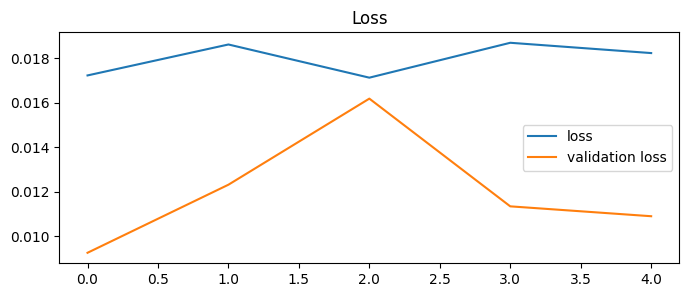

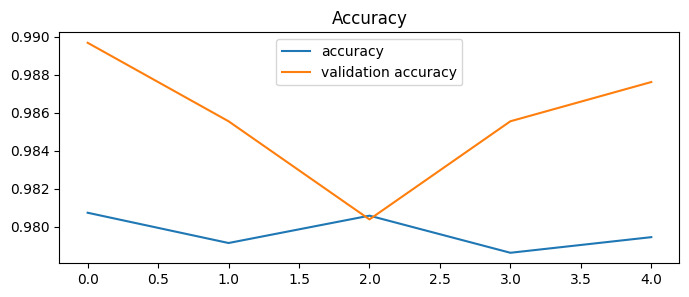

In [17]:
plt.figure(figsize=(8,3))
plt.title('Loss')
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

plt.figure(figsize=(8, 3))
plt.title('Accuracy')
plt.plot(history.history['binary_accuracy'], label='accuracy')
plt.plot(history.history['val_binary_accuracy'], label='validation accuracy')
plt.legend()
plt.show()